In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

In [4]:
df1 = pd.read_csv('Outlet-o.csv') # Reading Data
df2 = pd.read_csv('Outlet-p.csv')
df3 = pd.read_csv('Outlet-q.csv')

df1 = df1.head(9301)
df2 = df2.head(7603)
df3 = df3.head(14432)

# Converting to datetime datatype
df1['TransactionDateTime1'] = pd.to_datetime(df1['TransactionDateTime1'], infer_datetime_format=True)
df2['TransactionDateTime1'] = pd.to_datetime(df2['TransactionDateTime1'], infer_datetime_format=True)
df3['TransactionDateTime1'] = pd.to_datetime(df3['TransactionDateTime1'], infer_datetime_format=True)

# Grouping on Outlet Number, Pump Number, Transaction Hour and aggregating the Quantity
d1 = df1.groupby([df1['OutletNumber'], df1['PumpNumber1'], df1['TransactionDateTime1'].dt.hour]).agg({'Quantity1':'sum'})
d2 = df2.groupby([df2['OutletNumber'], df2['PumpNumber1'], df2['TransactionDateTime1'].dt.hour]).agg({'Quantity1':'sum'})
d3 = df3.groupby([df3['OutletNumber'], df3['PumpNumber1'], df3['TransactionDateTime1'].dt.hour]).agg({'Quantity1':'sum'})

frames = [d1, d2, d3]
d = pd.concat(frames) # Combining all the outlets

# Converting the transactions hour into columns via pivot table
p = d.pivot_table('Quantity1', ['OutletNumber', 'PumpNumber1'], 'TransactionDateTime1')
p.head(30)

TransactionDateTime1           0        1        2        3       4       5   \
OutletNumber PumpNumber1                                                       
Outlet-o     2             321.56    20.54      NaN      NaN    9.66  135.44   
             3             138.20      NaN      NaN      NaN     NaN   16.76   
Outlet-p     2                NaN      NaN      NaN      NaN     NaN     NaN   
             3                NaN      NaN      NaN      NaN     NaN     NaN   
Outlet-q     2            1750.50  1466.50  1111.22  1030.06  663.97  716.34   
             4               8.80     0.51     2.05     7.29   17.41    1.03   

TransactionDateTime1          6        7        8        9   ...       14  \
OutletNumber PumpNumber1                                     ...            
Outlet-o     2            430.65   376.38  1561.94  3004.25  ...  1444.53   
             3             10.41   127.71   138.72   844.39  ...   788.79   
Outlet-p     2              0.03   475.64   975.99  1434.52  ...  1111.41   
             3              0.00   209.48   569.50  1064.87  ...   202.64   
Outlet-q     2            804.91  1820.54  2581.71  4158.43  ...  4016.03   
             4              0.00    16.32   127.09   136.75  ...   158.33   

TransactionDateTime1           15       16       17       18       19  \
OutletNumber PumpNumber1                                                
Outlet-o     2            1382.11  1622.83  1823.53  2159.63  1431.02   
             3             439.67   451.00   585.41   519.65   308.82   
Outlet-p     2             876.45   924.32   735.51  1090.09  1112.29   
             3             344.35   624.32   366.13   407.27   310.19   
Outlet-q     2            3333.20  3578.57  2802.13  2935.66  3095.09   
             4              69.19      NaN    21.82     2.05    22.83   

TransactionDateTime1           20       21       22       23  
OutletNumber PumpNumber1                                      
Outlet-o     2            1607.74  1302.76   628.47   504.43  
             3             355.98   232.18    68.75    76.08  
Outlet-p     2            1075.99   514.64      NaN      NaN  
             3             207.59    35.81      NaN      NaN  
Outlet-q     2            2549.56  1558.53  2093.38  2024.04  
             4              43.04    22.52    13.65    40.23  

[6 rows x 24 columns]

In [5]:
p.replace(np.nan, 0.00, inplace = True) # Replacing the null values with 0.00

da = p.max(axis = 1).reset_index() # Retreiving the maximum volume of each pump 
da.columns = ['OutletNumber', 'PumpNumber1', 'Quantity1']

db = p.idxmax(axis = 1).reset_index() # Retreiving the hour at which the pump has maximum volume
db.columns =  ['OutletNumber', 'PumpNumber1', 'TransactionDateTime1']

c = pd.merge(da, db) # Merging the table of maximum volume of each pump and at what hour of all outlets 

oto = c.loc[c['OutletNumber'] == 'Outlet-o'] # Seperating outlet wise data
otp = c.loc[c['OutletNumber'] == 'Outlet-p']
otq = c.loc[c['OutletNumber'] == 'Outlet-q']
otq
#c.head(30)

,OutletNumber,PumpNumber1,Quantity1,TransactionDateTime1
4,Outlet-q,2,4582.1,13
5,Outlet-q,4,160.4,13


In [6]:
# Sort the data on maximum volume of each outlet peak hour
c.sort_values(['Quantity1'], axis = 0, ascending = False, inplace = True)
c3 = c.groupby('OutletNumber').first().reset_index()
c3 = pd.DataFrame(c3)
c3.head(10)

,OutletNumber,PumpNumber1,Quantity1,TransactionDateTime1
0,Outlet-o,2,3004.25,9
1,Outlet-p,2,1552.31,11
2,Outlet-q,2,4582.10,13


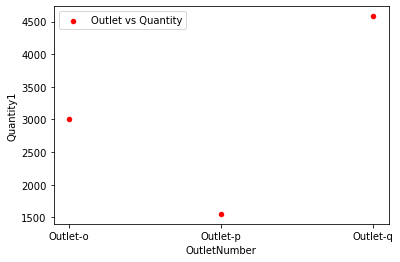

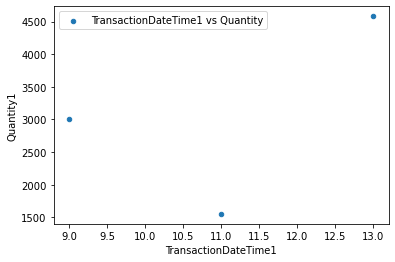

In [26]:
# Visual representation of data
ax = c3.plot(kind= 'scatter', x = 'OutletNumber', y = 'Quantity1', color = 'r', label ='Outlet vs Quantity')
c3.plot(kind = 'scatter', x = 'TransactionDateTime1', y = 'Quantity1', label = 'TransactionDateTime1 vs Quantity')

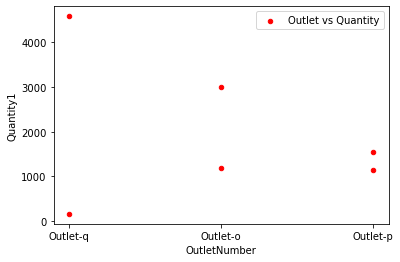

In [21]:
c.plot(kind= 'scatter', x = 'OutletNumber', y = 'Quantity1', color = 'r', label ='Outlet vs Quantity')

In [9]:
# Individual Trade Area Clustering
x = c3.iloc[:, [1, 2, 3]].values
kmean = KMeans(n_clusters=2)

In [10]:
y_kmeans = kmean.fit_predict(x) # Categorised the clusters 
print(y_kmeans)

[0 0 1]


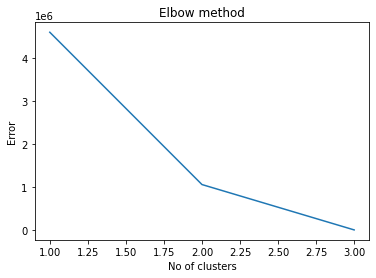

In [22]:
# Elbow Method to determine the number of clusters
Error =[]
for i in range(1, 4):
    kmeans = KMeans(n_clusters = i).fit(x)
    kmeans.fit(x)
    Error.append(kmeans.inertia_)
plt.plot(range(1, 4), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

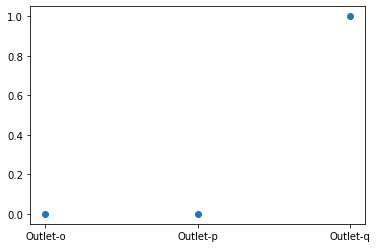

In [23]:
x1 = c3['OutletNumber']
y1 = y_kmeans
plt.scatter(x1, y1, cmap = 'rainbow') # clustered data plot of individual outlet

Text(0, 0.5, 'Time of Hour')

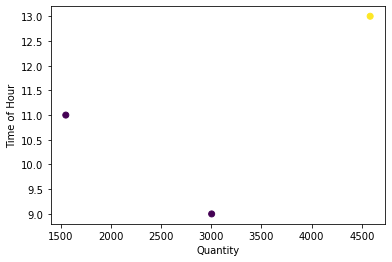

In [24]:
plt.scatter(x[:, 1], x[:, 2], c = y_kmeans)
plt.xlabel('Quantity')
plt.ylabel('Time of Hour')

In [25]:
print('****Outlet-o Median:', oto['Quantity1'].median()) # Individual Outlet Median
oto.head(2)

****Outlet-o Median: 2095.51


,OutletNumber,PumpNumber1,Quantity1,TransactionDateTime1
0,Outlet-o,2,3004.25,9
1,Outlet-o,3,1186.77,10


In [15]:
print('****Outlet-p Median:', otp['Quantity1'].median()) # Individual Outlet Median
otp.head(2)

****Outlet-p Median: 1350.2549999999972


,OutletNumber,PumpNumber1,Quantity1,TransactionDateTime1
2,Outlet-p,2,1552.31,11
3,Outlet-p,3,1148.20,10


In [16]:
print('****Outlet-q Median:', otq['Quantity1'].median()) # Individual Outlet Median
otq.head(2)

****Outlet-q Median: 2371.250000000009


,OutletNumber,PumpNumber1,Quantity1,TransactionDateTime1
4,Outlet-q,2,4582.1,13
5,Outlet-q,4,160.4,13
